# X3DH

In [ ]:
!pip install pynacl cryptography matplotlib

In [41]:
from nacl.public import PrivateKey, PublicKey, Box
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes

### X3DH Code

In [42]:
class X3DH:
    def __init__(self, is_initiator=True):
        # Identity key (long-term)
        self.identity_key = PrivateKey.generate()
        
        if is_initiator:
            # Ephemeral key (EK) for the initiator (Alice)
            self.ephemeral_key = PrivateKey.generate()
        else:
            # Signed prekey (SPK) and One-Time prekey (OTPK) for the receiver (Bob)
            self.signed_prekey = PrivateKey.generate()

    def get_public_keys(self):
        """Return public keys for identity, signed, and one-time prekeys (if available)."""
        keys = {
            'identity_key': self.identity_key.public_key
        }
        if hasattr(self, 'signed_prekey'):
            keys['signed_prekey'] = self.signed_prekey.public_key
        if hasattr(self, 'ephemeral_key'):
            keys['ephemeral_key'] = self.ephemeral_key.public_key
        return keys

    def perform_dh(self, private_key, recipient_public_key):
        """Perform Diffie-Hellman using NaCl's Box object."""
        box = Box(private_key, recipient_public_key)
        return box.shared_key()  # This is the shared secret

    def generate_shared_secret(self, recipient_public_keys):
        """Perform Diffie-Hellman to generate shared secrets using available keys."""
        shared_secrets = {}

        if hasattr(self, 'ephemeral_key'):  # Alice's side (initiator)
            # DH1: Ephemeral key of Alice with Signed Prekey of Bob
            shared_secrets['dh1'] = self.perform_dh(self.ephemeral_key, recipient_public_keys['signed_prekey'])
            #print(f"Alice DH1: {shared_secrets['dh1']}")

            # DH2: Alice’s Identity Key with Bob’s Signed Prekey
            shared_secrets['dh2'] = self.perform_dh(self.identity_key, recipient_public_keys['signed_prekey'])
            #print(f"Alice DH2: {shared_secrets['dh2']}")

            # DH3: Alice’s Ephemeral Key with Bob’s Identity Key
            shared_secrets['dh3'] = self.perform_dh(self.ephemeral_key, recipient_public_keys['identity_key'])
            #print(f"Alice DH3: {shared_secrets['dh3']}")

        elif hasattr(self, 'signed_prekey'):  # Bob’s side (receiver)
            # DH1: Signed Prekey of Bob with Ephemeral key of Alice
            shared_secrets['dh1'] = self.perform_dh(self.signed_prekey, recipient_public_keys['ephemeral_key'])
            #print(f"Bob DH1: {shared_secrets['dh1']}")

            # DH2: Bob’s Signed Prekey with Alice’s Identity Key
            shared_secrets['dh2'] = self.perform_dh(self.signed_prekey, recipient_public_keys['identity_key'])
            #print(f"Bob DH2: {shared_secrets['dh2']}")

            # DH3: Bob’s Identity Key with Alice’s Ephemeral Key
            shared_secrets['dh3'] = self.perform_dh(self.identity_key, recipient_public_keys['ephemeral_key'])
            #print(f"Bob DH3: {shared_secrets['dh3']}")

        return shared_secrets

def derive_session_key(shared_secrets):
    """Combine shared secrets into a session key using HKDF."""
    combined_secrets = b''.join(shared_secrets.values())  # Concatenate DH results

    hkdf = HKDF(
        algorithm=hashes.SHA256(),  # Correctly import the hashing algorithm from cryptography
        length=32,  # 256-bit key
        salt=None,
        info=b'x3dh session key'
    )

    session_key = hkdf.derive(combined_secrets)
    return session_key

# Double Ratchet Code

In [43]:
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from nacl.public import PrivateKey, Box
import hmac
import hashlib
import os

### Symmetric Ratchet Code

In [44]:
class SymmetricRatchet:
    def __init__(self, initial_key):
        self.current_key = initial_key  # Initial chain key

    def hmac_derive_key(self, key, input_bytes):
        """Derive a new key using HMAC with SHA-256."""
        return hmac.new(key, input_bytes, hashlib.sha256).digest()

    def ratchet(self):
        """Update the chain key using HMAC-SHA256 and derive a new encryption key."""
        # The input to HMAC could be any sequence, but let's use a constant like b'chain key' to keep it consistent
        self.current_key = self.hmac_derive_key(self.current_key, b'chain key')
        #print(f"New chain key (derived using HMAC): {self.current_key.hex()}")
        return self.current_key
    
    def move_ratchet_forward(self):
        """Explicitly move the ratchet forward without encrypting or decrypting."""
        new_key = self.ratchet()
        print(f"Ratchet moved forward, new key: {new_key.hex()}")
        return new_key

    def encrypt(self, plaintext, nonce=None):
        """Encrypt the message using AES-GCM with the current key."""
        key = self.ratchet()  # Update the key after each message
        if nonce is None:
            nonce = os.urandom(12)  # 96-bit nonce
        cipher = Cipher(algorithms.AES(key), modes.GCM(nonce))
        encryptor = cipher.encryptor()
        ciphertext = encryptor.update(plaintext) + encryptor.finalize()
        #print(f"Encryption tag: {encryptor.tag.hex()}")
        return ciphertext, nonce, encryptor.tag

    def decrypt(self, ciphertext, nonce, tag):
        """Decrypt the message using AES-GCM with the current key."""
        key = self.ratchet()  # Update the key after each message
        cipher = Cipher(algorithms.AES(key), modes.GCM(nonce, tag))
        decryptor = cipher.decryptor()
        try:
            plaintext = decryptor.update(ciphertext) + decryptor.finalize()
            return plaintext
        except Exception as e:
            print(f"Decryption error: {e}")
            raise


### DH Ratchet

In [45]:
class DHRatchet:
    def __init__(self, private_key=None):
        """Initialize the DH ratchet. If no private key is given, generate a new one."""
        self.private_key = private_key if private_key else PrivateKey.generate()
        self.public_key = self.private_key.public_key

    def ratchet(self, received_public_key):
        """Perform a Diffie-Hellman exchange and derive a new shared secret."""
        box = Box(self.private_key, received_public_key)
        shared_secret = box.shared_key()
        return shared_secret

    def update_key_pair(self):
        """Generate a new DH key pair."""
        self.private_key = PrivateKey.generate()
        self.public_key = self.private_key.public_key

### Double Ratchet

In [46]:
class DoubleRatchet:
    def __init__(self, initial_shared_secret=None, my_private_key=None, their_public_key=None, dh_frequency=5):
        """Initialize Double Ratchet with DH and Symmetric Ratchets."""
        # Initialize DH Ratchet
        self.dh_ratchet = DHRatchet(private_key=my_private_key)  # My private key
        self.their_public_key = their_public_key  # Their public key
        self.dh_frequency = dh_frequency
        
        # Track the number of messages sent by this party
        self.sent_message_count = 0  # Messages sent by this party
        
        if initial_shared_secret:
            # Derive initial symmetric key using the shared secret from X3DH
            hkdf = HKDF(
                algorithm=hashes.SHA256(),
                length=32,
                salt=None,
                info=b'initial symmetric key'
            )
            self.initial_symmetric_key = hkdf.derive(initial_shared_secret)
            #print(f"Initial symmetric key: {self.initial_symmetric_key.hex()}")
        else:
            # If no initial shared secret is provided, generate a random initial symmetric key
            self.initial_symmetric_key = os.urandom(32)
            #print(f"Generated random initial symmetric key: {self.initial_symmetric_key.hex()}")

        # Initialize symmetric ratchet with the derived/generated symmetric key
        self.symmetric_ratchet = SymmetricRatchet(self.initial_symmetric_key)

    def encrypt(self, plaintext):
        """Encrypt the message using the current state of the Double Ratchet."""
        # Increment the sent message counter
        self.sent_message_count += 1
        #print("Message sent:", self.sent_message_count)
        # Reset DH ratchet every 5 messages sent by this party
        if self.sent_message_count % self.dh_frequency == 0:
            #print(f"Resetting DH ratchet after {self.sent_message_count} messages sent.")
            self.dh_ratchet.update_key_pair()  # Generate a new DH key pair
            new_shared_secret = self.dh_ratchet.ratchet(self.their_public_key)
            #print(f"New shared secret (after DH reset): {new_shared_secret.hex()}")

            # Update the symmetric ratchet with the new shared secret
            hkdf = HKDF(
                algorithm=hashes.SHA256(),
                length=32,
                salt=None,
                info=b'updated symmetric key'
            )
            new_symmetric_key = hkdf.derive(new_shared_secret)
            self.symmetric_ratchet = SymmetricRatchet(new_symmetric_key)

        # Use the symmetric ratchet to encrypt the message
        ciphertext, nonce, tag = self.symmetric_ratchet.encrypt(plaintext)

        # Return the ciphertext, nonce, tag, and the sender's new public key (for DH ratchet if any)
        return ciphertext, nonce, tag, self.dh_ratchet.public_key

    def decrypt(self, ciphertext, nonce, tag, received_public_key):
        """Decrypt the message and update the Double Ratchet state."""
        # Perform DH ratchet step if the received public key is different from the current one
        if received_public_key != self.their_public_key:
            self.their_public_key = received_public_key
            #print("Performing DH ratchet due to new public key from sender.")
            new_shared_secret = self.dh_ratchet.ratchet(received_public_key)
            #print(f"New shared secret (on receiver's side): {new_shared_secret.hex()}")

            # Derive updated symmetric key using the new shared secret
            hkdf = HKDF(
                algorithm=hashes.SHA256(),
                length=32,
                salt=None,
                info=b'updated symmetric key'
            )
            updated_symmetric_key = hkdf.derive(new_shared_secret)
            #print(f"Updated symmetric key (on receiver's side): {updated_symmetric_key.hex()}")

            # Update the symmetric ratchet with the new key
            self.symmetric_ratchet = SymmetricRatchet(updated_symmetric_key)

        # Decrypt the message using the symmetric ratchet
        plaintext = self.symmetric_ratchet.decrypt(ciphertext, nonce, tag)
        return plaintext


# Full Signal Protocol

In [47]:
class SignalProtocol:
    def __init__(self, is_initiator=True, dh_frequency=5):
        """
        Initializes the protocol for either Alice (initiator) or Bob (receiver).
        X3DH for key exchange and Double Ratchet for message communication.
        """
        self.dh_frequency = dh_frequency
        self.is_initiator = is_initiator
        self.x3dh = X3DH(is_initiator=is_initiator)

        self.dh_private_key=PrivateKey.generate()
        self.dh_public_key=self.dh_private_key.public_key

        # Store the session key (after key exchange)
        self.session_key = None

        # Double Ratchet instance
        self.double_ratchet = None

    def initiate_key_exchange(self, recipient_public_keys=None, recipient_dh_public_keys=None):
        """Initiate X3DH key exchange and generate the session key."""
        if self.is_initiator:
            # Alice initiates the key exchange
            if recipient_public_keys is None:
                raise ValueError("Recipient public keys required for key exchange.")
            
            # Generate shared secrets and session key
            shared_secrets = self.x3dh.generate_shared_secret(recipient_public_keys)
            self.session_key = derive_session_key(shared_secrets)
            #print(f"Session Key (Initiator's side): {self.session_key.hex()}")
            
            # After X3DH, initialize Double Ratchet with the session key
            self.double_ratchet = DoubleRatchet(
                initial_shared_secret=self.session_key,
                my_private_key=self.dh_private_key,
                their_public_key=recipient_dh_public_keys,
                dh_frequency=self.dh_frequency
            )

            # Get Alice's public keys to send to Bob before deleting the ephemeral key
            my_public_keys = self.x3dh.get_public_keys()

            # After the shared secret is derived, securely erase the ephemeral key
            #print("Deleting Alice's ephemeral key after use for forward secrecy.")
            self.x3dh.ephemeral_key = PrivateKey.generate()  # Securely erase the ephemeral key

            return my_public_keys  # Return Alice's public keys to Bob

        else:
            # Bob completes the key exchange
            shared_secrets = self.x3dh.generate_shared_secret(recipient_public_keys)
            self.session_key = derive_session_key(shared_secrets)
            #print(f"Session Key (Receiver's side): {self.session_key.hex()}")

            # After X3DH, initialize Double Ratchet with the session key
            self.double_ratchet = DoubleRatchet(
                initial_shared_secret=self.session_key,
                my_private_key=self.dh_private_key,
                their_public_key=recipient_dh_public_keys,
                dh_frequency=self.dh_frequency
            )

    def send_message(self, plaintext):
        """Encrypt a message using the Double Ratchet."""
        if not self.double_ratchet:
            raise ValueError("Double Ratchet has not been initialized. Perform key exchange first.")

        ciphertext, nonce, tag, public_key = self.double_ratchet.encrypt(plaintext)
        return {
            'ciphertext': ciphertext,
            'nonce': nonce,
            'tag': tag,
            'public_key': public_key
        }

    def receive_message(self, message_bundle):
        """Decrypt a message using the Double Ratchet."""
        if not self.double_ratchet:
            raise ValueError("Double Ratchet has not been initialized. Perform key exchange first.")

        ciphertext = message_bundle['ciphertext']
        nonce = message_bundle['nonce']
        tag = message_bundle['tag']
        received_public_key = message_bundle['public_key']

        plaintext = self.double_ratchet.decrypt(ciphertext, nonce, tag, received_public_key)
        return plaintext.decode()
    
    def sym_ratchet_forward(self):
        self.double_ratchet.symmetric_ratchet.move_ratchet_forward()
    
    def get_dh_public_key(self):
        return self.dh_public_key


# Evaluation

In [48]:
import time
import sys
import matplotlib.pyplot as plt

In [49]:
# 1. Measure X3DH Key Exchange Overhead
def measure_x3dh_overhead(num_iterations=100000):
    alice_protocol = SignalProtocol(is_initiator=True)
    bob_protocol = SignalProtocol(is_initiator=False)

    alice_times = []
    bob_times = []

    for _ in range(num_iterations):
        # Measure Alice's key exchange time
        start_time = time.time()
        bob_public_keys = bob_protocol.x3dh.get_public_keys()
        alice_public_keys = alice_protocol.initiate_key_exchange(bob_public_keys, bob_protocol.get_dh_public_key())
        end_time = time.time()
        alice_times.append((end_time - start_time) * 1000)  # Convert to ms

        # Measure Bob's key exchange time
        start_time = time.time()
        bob_protocol.initiate_key_exchange(alice_public_keys, alice_protocol.get_dh_public_key())
        end_time = time.time()
        bob_times.append((end_time - start_time) * 1000)  # Convert to ms

    avg_alice_time = sum(alice_times) / len(alice_times)
    avg_bob_time = sum(bob_times) / len(bob_times)

    return avg_alice_time, avg_bob_time

In [50]:
# Function to measure encryption, decryption, and plain text transmission times
def measure_overhead(plaintext_message, num_iterations=10000, dh_frequency=5):
    alice_protocol = SignalProtocol(is_initiator=True, dh_frequency=dh_frequency)
    bob_protocol = SignalProtocol(is_initiator=False, dh_frequency=dh_frequency)

    bob_public_keys = bob_protocol.x3dh.get_public_keys()
    alice_public_keys = alice_protocol.initiate_key_exchange(bob_public_keys, bob_protocol.get_dh_public_key())
    bob_protocol.initiate_key_exchange(alice_public_keys, alice_protocol.get_dh_public_key())

    alice_times = []
    bob_times = []
    plain_text_times = []

    # Perform encryption/decryption with Double Ratchet and plain text transmission
    for _ in range(num_iterations):
        # Measure message encryption time (Alice) - Double Ratchet
        start_time = time.perf_counter()
        message_bundle = alice_protocol.send_message(plaintext_message)
        end_time = time.perf_counter()
        alice_times.append((end_time - start_time) * 1000)  # Convert to ms

        # Measure message decryption time (Bob) - Double Ratchet
        start_time = time.perf_counter()
        decrypted_message = bob_protocol.receive_message(message_bundle)
        end_time = time.perf_counter()
        bob_times.append((end_time - start_time) * 1000)  # Convert to ms

        # Measure plain text transmission time (without encryption)
        start_time = time.perf_counter()
        # Simulate plain text transmission without encryption
        received_plain_text = plaintext_message  # No encryption or decryption
        end_time = time.perf_counter()
        plain_text_times.append((end_time - start_time) * 1000)  # Convert to ms

    # Calculate average times
    avg_alice_time = sum(alice_times) / len(alice_times)
    avg_bob_time = sum(bob_times) / len(bob_times)
    avg_plain_text_time = sum(plain_text_times) / len(plain_text_times)

    return avg_alice_time, avg_bob_time, avg_plain_text_time

In [51]:
# 2. Measure Communication Overhead
def calculate_communication_overhead(plaintext_message, dh_frequency=5):
    # Initialize protocols for Alice and Bob
    alice_protocol = SignalProtocol(is_initiator=True, dh_frequency=dh_frequency)
    bob_protocol = SignalProtocol(is_initiator=False, dh_frequency=dh_frequency)

    # Perform X3DH key exchange before messaging
    bob_public_keys = bob_protocol.x3dh.get_public_keys()
    alice_public_keys = alice_protocol.initiate_key_exchange(bob_public_keys, bob_protocol.get_dh_public_key())
    bob_protocol.initiate_key_exchange(alice_public_keys, alice_protocol.get_dh_public_key())
    
    # Measure size of encrypted message (Double Ratchet)
    message_bundle = alice_protocol.send_message(plaintext_message)
    encrypted_message_size = sum(sys.getsizeof(value) for value in message_bundle.values())

    # Measure size of plain text message (no encryption)
    plain_text_size = sys.getsizeof(plaintext_message)

    return encrypted_message_size, plain_text_size

In [52]:
def test_x3dh_time_overhead(num_iterations):
    avg_alice_time, avg_bob_time = measure_x3dh_overhead(num_iterations)
    print(f"\nX3DH Key Exchange Overhead for {num_iterations} exchanges:")
    print(f"Average time (Alice): {avg_alice_time:.6f} ms")
    print(f"Average time (Bob): {avg_bob_time:.6f} ms")


def test_double_ratchet_message_overhead(num_iterations):
    message_lengths = [10, 100, 1000]  # Bytes

    for message_length in message_lengths:
        plaintext_message = b"A" * message_length  # Create a message of the given length

        avg_alice_time, avg_bob_time, avg_plain_text_time = measure_overhead(plaintext_message, num_iterations)

        print(f"\nDouble Ratchet Overhead for {num_iterations} exchanges and message length {message_length} bytes:")
        print(f"Average message encryption time (Alice): {avg_alice_time:.6f} ms")
        print(f"Average message decryption time (Bob): {avg_bob_time:.6f} ms")
        print(f"Average plain text transmission time: {avg_plain_text_time:.6f} ms")


def test_double_ratchet_dh_frequency(num_iterations):
    message_length = 1000  # Bytes
    dh_frequencies = [1, 5, 10, 50, 100]  # DH ratchet frequencies

    plaintext_message = b"A" * message_length  # Create a message of the given length

    alice_times = []
    bob_times = []
    plain_text_times = []

    for dh_frequency in dh_frequencies:
        avg_alice_time, avg_bob_time, avg_plain_text_time = measure_overhead(plaintext_message, num_iterations, dh_frequency)

        alice_times.append(avg_alice_time)
        bob_times.append(avg_bob_time)
        plain_text_times.append(avg_plain_text_time)

        print(f"\nDouble Ratchet Overhead for {num_iterations} exchanges and message length {message_length} bytes with DH frequency {dh_frequency}:")
        print(f"Average message encryption time (Alice): {avg_alice_time:.6f} ms")
        print(f"Average message decryption time (Bob): {avg_bob_time:.6f} ms")
        print(f"Average plain text transmission time: {avg_plain_text_time:.6f} ms")

    # Plotting the graph
    plt.figure(figsize=(10, 6))

    plt.plot(dh_frequencies, alice_times, label='Encryption Time (Alice)', marker='o', color='blue')
    plt.plot(dh_frequencies, bob_times, label='Decryption Time (Bob)', marker='o', color='green')
    plt.plot(dh_frequencies, plain_text_times, label='Plain Text Transmission Time', marker='o', color='red')

    plt.title(f'Double Ratchet Time Overhead vs DH Frequency\nMessage Length: {message_length} Bytes')
    plt.xlabel('DH Frequency (Messages per DH Key Exchange)')
    plt.ylabel('Average Time (ms)')
    plt.legend()
    plt.grid(True)
    plt.xticks(dh_frequencies)
    plt.savefig('double_ratchet_overhead.png', format='png', dpi=300)
    plt.show()

def test_communication_overhead(message_lengths, dh_frequency=5):
    encrypted_sizes = []
    plain_sizes = []

    for message_length in message_lengths:
        plaintext_message = b"A" * message_length  # Create a message of the given length
        encrypted_size, plain_size = calculate_communication_overhead(plaintext_message, dh_frequency)

        encrypted_sizes.append(encrypted_size)
        plain_sizes.append(plain_size)

        print(f"\nMessage Length: {message_length} bytes")
        print(f"Encrypted message size: {encrypted_size} bytes")
        print(f"Plain text size: {plain_size} bytes")
        print(f"Communication overhead: {encrypted_size - plain_size} bytes")



X3DH Key Exchange Overhead for 10000 exchanges:
Average time (Alice): 0.281700 ms
Average time (Bob): 0.248200 ms

Double Ratchet Overhead for 10000 exchanges and message length 10 bytes:
Average message encryption time (Alice): 0.040853 ms
Average message decryption time (Bob): 0.037491 ms
Average plain text transmission time: 0.000072 ms

Double Ratchet Overhead for 10000 exchanges and message length 100 bytes:
Average message encryption time (Alice): 0.040739 ms
Average message decryption time (Bob): 0.037334 ms
Average plain text transmission time: 0.000070 ms

Double Ratchet Overhead for 10000 exchanges and message length 1000 bytes:
Average message encryption time (Alice): 0.041056 ms
Average message decryption time (Bob): 0.037819 ms
Average plain text transmission time: 0.000071 ms

Double Ratchet Overhead for 10000 exchanges and message length 1000 bytes with DH frequency 1:
Average message encryption time (Alice): 0.140085 ms
Average message decryption time (Bob): 0.109907 m

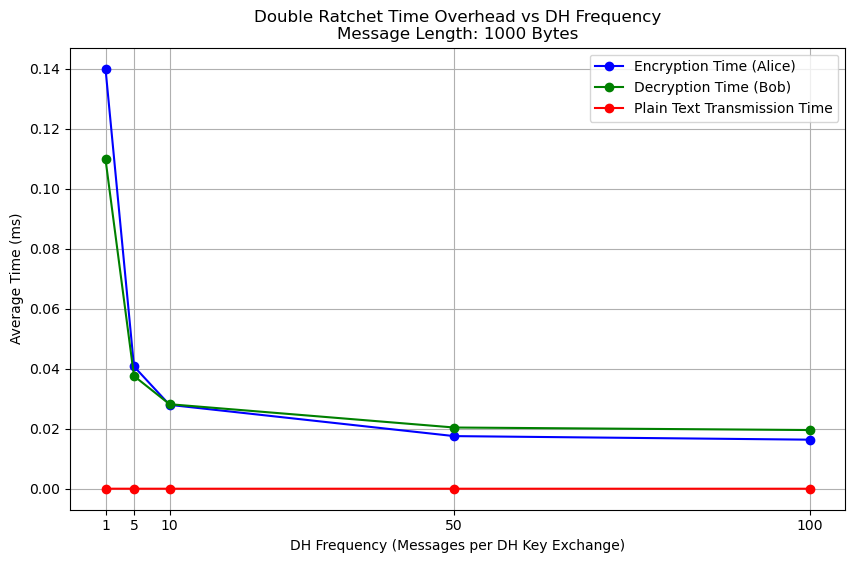

In [53]:
iterations = 10000

test_x3dh_time_overhead(iterations)
test_double_ratchet_message_overhead(iterations)
test_double_ratchet_dh_frequency(iterations)

In [54]:
# Example usage: Define message lengths to test
message_lengths = [100, 500, 1000, 5000, 10000]  # Varying message lengths

# Test communication overhead with default DH frequency (5)
test_communication_overhead(message_lengths, dh_frequency=5)


Message Length: 100 bytes
Encrypted message size: 283 bytes
Plain text size: 133 bytes
Communication overhead: 150 bytes

Message Length: 500 bytes
Encrypted message size: 683 bytes
Plain text size: 533 bytes
Communication overhead: 150 bytes

Message Length: 1000 bytes
Encrypted message size: 1183 bytes
Plain text size: 1033 bytes
Communication overhead: 150 bytes

Message Length: 5000 bytes
Encrypted message size: 5183 bytes
Plain text size: 5033 bytes
Communication overhead: 150 bytes

Message Length: 10000 bytes
Encrypted message size: 10183 bytes
Plain text size: 10033 bytes
Communication overhead: 150 bytes
